# **5. Transformer**

> 이번 실습에서는 NLP 분야에서 가장 많이 사용되고 있으며, Computer Vision 분야 등 다양한 분야에서도 활용되고 있는 **Transformer** 모델에 대해 학습한다.

>Transformer 모델은 이전 단원에서 학습한 attention 모듈을 발전시킨 Multi-head Attention으로 구성된 모델 구조이다.
>
>Multi-head Attention에 대해 먼저 학습해보자.


> ## 0. Setup
> 필요한 package를 import한다.

In [1]:
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import math
import numpy as np
import os

### **예시 데이터 생성**

> Multi-head Attention 구현에 활용하기 위한 예시 데이터를 만들어보자.

In [18]:
pad_id = 0
vocab_size = 100 # 다룰수 있는 단어의 개수

data = [
  [62, 13, 47, 39, 78, 33, 56, 13],
  [60, 96, 51, 32, 90],
  [35, 45, 48, 65, 91, 99, 92, 10, 3, 21],
  [66, 88, 98, 47],
  [77, 65, 51, 77, 19, 15, 35, 19, 23]
]

>이전 단원에서 다뤘던 것처럼, 모든 문장의 길이가 같아지도록 0 token을 padding으로 추가한다.

In [19]:
def padding(data):
  max_len = len(max(data, key=len))
  print(f"Maximum sequence length: {max_len}")

  for i, seq in enumerate(tqdm(data)):
    if len(seq) < max_len:
      data[i] = seq + [pad_id] * (max_len - len(seq))

  return data, max_len

In [20]:
data, max_len = padding(data)

Maximum sequence length: 10


100%|██████████| 5/5 [00:00<00:00, 7065.88it/s]


In [21]:
data

[[62, 13, 47, 39, 78, 33, 56, 13, 0, 0],
 [60, 96, 51, 32, 90, 0, 0, 0, 0, 0],
 [35, 45, 48, 65, 91, 99, 92, 10, 3, 21],
 [66, 88, 98, 47, 0, 0, 0, 0, 0, 0],
 [77, 65, 51, 77, 19, 15, 35, 19, 23, 0]]

### **Hyperparameter 세팅 및 embedding**

> Multi-head Attention을 위한 Hyper-parameter를 설정한다.
>
>또 Embedding layer를 선언한 후 위에서 만든 예시 데이터의 embedding을 구한다.
>
>Embedding layer는 `nn.Embedding(vocab_size, d_model)`로 선언할 수 있으며, token_id 를 입력값으로 받아 그에 해당하는 embedding vector를 반환하는 일종의 lookup table이다.
>
>반환되는 embedding vector도 일반적인 neural network layer의 parameter처럼 학습되기 때문에 학습 가능한 모델의 일부분으로서 *layer*라는 표현을 사용한다.

In [22]:
d_model = 512  # model의 hidden size
num_heads = 8  # head의 개수

In [24]:
embedding = nn.Embedding(vocab_size, d_model) # vocab_size 100개중에서 하나씩 d_model 512차원의 벡터로 매핑 : 초기 가중치라고 생각

# B: batch size, L: maximum sequence length
batch = torch.LongTensor(data)  # (B, L)
batch_emb = embedding(batch)  # (B, L, d_model)

In [25]:
print(f'batch_emb shape: {batch_emb.shape}')

batch_emb shape: torch.Size([5, 10, 512])


## 1. Multi-head Attention

> 먼저 Multi-head attention 코드를 구현한다.
>
>이전 단원에서 다뤘던 attention은 head가 한 개인 single-head Attention이고, head의 개수를 늘려서 multi-head Attention을 구현할 수 있다.
>

### **Linear transformation & 여러 head로 나누기**

> Multi-head attention 내에서 쓰이는 linear transformation matrix들을 정의한다.

In [29]:
w_q = nn.Linear(d_model, d_model)
w_k = nn.Linear(d_model, d_model)
w_v = nn.Linear(d_model, d_model)

In [30]:
w_0 = nn.Linear(d_model, d_model)

In [31]:
q = w_q(batch_emb)  # (B, L, d_model)
k = w_k(batch_emb)  # (B, L, d_model)
v = w_v(batch_emb)  # (B, L, d_model)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([5, 10, 512])
torch.Size([5, 10, 512])
torch.Size([5, 10, 512])


> q, k, v를 `num_head`개의 차원 분할된 여러 vector로 만들자.

In [32]:
batch_size = q.shape[0]
# sequence length = q.shape[1]
d_k = d_model // num_heads

q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([5, 10, 8, 64])
torch.Size([5, 10, 8, 64])
torch.Size([5, 10, 8, 64])


In [33]:
q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([5, 8, 10, 64])
torch.Size([5, 8, 10, 64])
torch.Size([5, 8, 10, 64])


### **Scaled dot-product self-attention 구현**

> 각 head에서 실행되는 self-attetion 과정이다.

In [ ]:
attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L) = [5, 8, 10, 10]
attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, L=query 갯수, L=key 갯수)

print(f'attention distribution shape: {attn_dists.shape}')
print(f'example of attention distribution : {attn_dists[0][0][0]}')


attention distribution shape: torch.Size([5, 8, 10, 10])
example of attention distribution : tensor([0.0939, 0.0950, 0.1090, 0.0902, 0.1640, 0.1402, 0.0798, 0.0950, 0.0664,
        0.0664], grad_fn=<SelectBackward0>)


In [ ]:
attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

print(attn_values.shape)

torch.Size([5, 8, 10, 64])


### **각 head의 결과물 병합**

> 각 head의 결과물을 concat 한 후 동일 차원으로 reshape하고, linear layer를 통해 최종 output을 계산한다.

In [ ]:
attn_values = attn_values.transpose(1, 2)  # (B, L, num_heads, d_k)
attn_values = attn_values.reshape(batch_size, -1, d_model)  # (B, L, d_model)

print(f'attn_values shape: {attn_values.shape}')

attn_values shape: torch.Size([5, 10, 512])


In [ ]:
outputs = w_0(attn_values)

print(f'outputs shape: {outputs.shape}')

outputs shape: torch.Size([5, 10, 512])


### **Multi-head Attention 모듈 코드**

> 위의 과정을 모두 합쳐 하나의 Multi-head attention 모듈을 구현해보자.

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self):
    super(MultiheadAttention, self).__init__()

    # Q, K, V projection 행렬
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    # Linear transformation for concatenated outputs
    self.w_0 = nn.Linear(d_model, d_model)

  def forward(self, q, k, v):
    batch_size = q.shape[0]

    q = self.w_q(q)  # (B, L, d_model)
    k = self.w_k(k)  # (B, L, d_model)
    v = self.w_v(v)  # (B, L, d_model)

    q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

    q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
    k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
    v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

    attn_values = self.self_attention(q, k, v)  # (B, num_heads, L, d_k)
    attn_values = attn_values.transpose(1, 2).contiguous().view(batch_size, -1, d_model)  # (B, L, num_heads, d_k) => (B, L, d_model)

    return self.w_0(attn_values)

  def self_attention(self, q, k, v):
    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)
    attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, L, L)

    attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

    ## torch.matmul -> torch.einsum으로 구현해보기!!!!!!!!!!, torch.bmm으로 구현해보기!!!!!!!!!!

    return attn_values

In [ ]:
multihead_attn = MultiheadAttention()

outputs = multihead_attn(batch_emb, batch_emb, batch_emb)  # (B, L, d_model)

In [ ]:
print(f'outputs shape: {outputs.shape}')

outputs shape: torch.Size([5, 10, 512])


## 2. Masked Multi-head Attention

> 이어서 masked multi-head attention에 대해 학습해보자.
>
>Transformer Decoder는 문장을 생성할 때 아직 생성되지 않은 앞선 위치 (subsequent)의 token을 참조할 수 없다.
>
>하지만 학습 과정에서는 정답 데이터를 가지고 있기 때문에, subsequent token을 masking을 통해 가려줘야 한다.
>
>예를 들어, t+1 위치의 단어를 생성할 때 t 이후의 token에 대해 masking을 해주어야 학습이 제대로 이루어진다.
>
>이를 위해 subsequent token에 대한 attention weight을 0으로 처리하는 Masked Multi-head Attention을 사용한다.

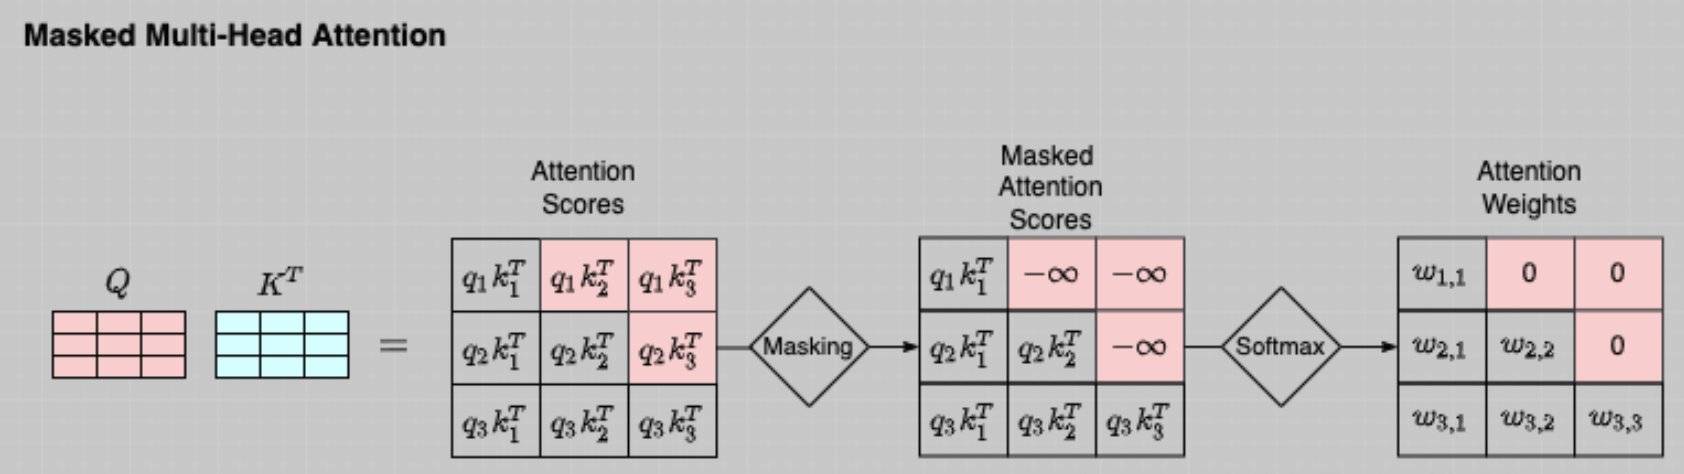

>- $Q = (q_1, q_2, ... , q_T)$: query 행렬
>- $K = (k_1, k_2, ... , k_T)$: key 행렬


### **Mask 생성**

> `True`는 attention이 적용될 부분, `False`는 masking될 위치이다.
>
>Padding을 맞출 필요는 없기 때문에 padding token에 mask를 `False`로 설정한다.

In [ ]:
padding_mask = (batch != pad_id).unsqueeze(1)  # (B, 1, L)

print(padding_mask)
print(padding_mask.shape)

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True, False, False]],

        [[ True,  True,  True,  True,  True, False, False, False, False, False]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True, False, False, False, False, False, False]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,  True, False]]])
torch.Size([5, 1, 10])



>`torch.tril` 함수를 통해 lower triangle 행렬을 생성해 subsequent token mask로 사용할 수 있다.

In [ ]:
nopeak_mask = torch.ones([1, max_len, max_len], dtype=torch.bool)  # (1, L, L)
nopeak_mask = torch.tril(nopeak_mask)  # (1, L, L)

print(nopeak_mask)
print(nopeak_mask.shape)

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])
torch.Size([1, 10, 10])


In [ ]:
mask = padding_mask & nopeak_mask  # (B, L, L)

print(mask)
print(mask.shape)

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False]],

        [[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  T

>0번 batch의 mask를 시각화해보자.

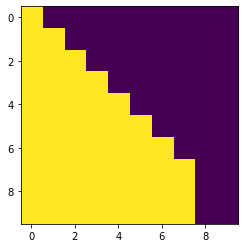

In [ ]:
plt.imshow(mask[0])

### **Linear transformation & 여러 head로 나누기**

In [ ]:
w_q = nn.Linear(d_model, d_model)
w_k = nn.Linear(d_model, d_model)
w_v = nn.Linear(d_model, d_model)

w_0 = nn.Linear(d_model, d_model)

In [ ]:
q = w_q(batch_emb)  # (B, L, d_model)
k = w_k(batch_emb)  # (B, L, d_model)
v = w_v(batch_emb)  # (B, L, d_model)

batch_size = q.shape[0]
d_k = d_model // num_heads

q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([5, 8, 10, 64])
torch.Size([5, 8, 10, 64])
torch.Size([5, 8, 10, 64])


### **Masking이 적용된 self-attention 구현**

> `tensor.masked_fill(masks, value)` 함수를 통해 `masks=True`인 위치에 value 값을 채워넣을 수 있다.

In [ ]:
attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)


In [ ]:
masks = mask.unsqueeze(1)  # (B, 1, L, L)
masked_attn_scores = attn_scores.masked_fill_(masks == False, -1 * torch.inf)  # (B, num_heads, L, L)

print(f'masks: {masks[0][0]}\n')
print(f'masked attention: {masked_attn_scores[0][0]}\n')
print(f'masked attention shape: {masked_attn_scores.shape}')

masks: tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False]])

masked attention: tensor([[ 0.3690,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 0.6682,  0.2688,    -inf,    -inf,    -inf,    -inf,  

> `-1* torch.inf`로 masking된 부분은 softmax 후 0이 된다.

In [ ]:
attn_dists = F.softmax(masked_attn_scores, dim=-1)  # (B, num_heads, L, L)

print(f'masked attention distribution: {attn_dists[0][0]}\n')
print(attn_dists.shape)

masked attention distribution: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5985, 0.4015, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3818, 0.2381, 0.3802, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3344, 0.2026, 0.2695, 0.1935, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2915, 0.2074, 0.1632, 0.1977, 0.1402, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2351, 0.1297, 0.1857, 0.1907, 0.1082, 0.1506, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1280, 0.1188, 0.0790, 0.1247, 0.1563, 0.1967, 0.1965, 0.0000, 0.0000,
         0.0000],
        [0.1925, 0.1291, 0.1021, 0.1153, 0.1206, 0.1000, 0.1114, 0.1291, 0.0000,
         0.0000],
        [0.0968, 0.1187, 0.0819, 0.1808, 0.1503, 0.1400, 0.1129, 0.1187, 0.0000,
         0.0000],
        [0.0968, 0.1187, 0.0819, 0.1808, 0.1503, 0.1400, 0.1129, 0.1187, 0.000

In [ ]:
attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

print(attn_values.shape)

### **Masking이 적용된 Multi-head Attention 모듈 코드**

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self):
    super(MultiheadAttention, self).__init__()

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    # Linear transformation for concatenated outputs
    self.w_0 = nn.Linear(d_model, d_model)

  def forward(self, q, k, v, mask=None):
    batch_size = q.shape[0]

    q = self.w_q(q)  # (B, L, d_model)
    k = self.w_k(k)  # (B, L, d_model)
    v = self.w_v(v)  # (B, L, d_model)

    q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

    q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
    k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
    v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

    attn_values = self.self_attention(q, k, v, mask=mask)  # (B, num_heads, L, d_k)
    attn_values = attn_values.transpose(1, 2).contiguous().view(batch_size, -1, d_model)  # (B, L, num_heads, d_k) => (B, L, d_model)

    return self.w_0(attn_values)

  def self_attention(self, q, k, v, mask=None):
    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)

    if mask is not None:
      mask = mask.unsqueeze(1)  # (B, 1, L, L) or  (B, 1, 1, L)
      attn_scores = attn_scores.masked_fill_(mask == False, -1*torch.inf)

    attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, L, L)

    attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

    return attn_values

In [ ]:
multihead_attn = MultiheadAttention()

outputs = multihead_attn(batch_emb, batch_emb, batch_emb, mask=mask)  # (B, L, d_model)

In [ ]:
print(outputs)
print(outputs.shape)

## 4. **Decoder Attention**

>Transformer는 이전 단원에서 학습한 Seq2Seq 모델과 같이 Encoder-Decoder 구조로 이루어져있다.
>
> Query, key, value가 같은 sequence에서 생성될 경우 이를 self-attention이라고 부른다.
>
>Encoder-Decoder 구조에서 encoder의 경우 self-attention을 사용하지만, decoder는 encoder에서 압축된 정보와 더불어 RNN과 비슷하게 이전 스텝에 생성된 문장에 대한 정보가 함께 들어가야 한다.
>
>이 경우, key와 value는 source sequence로부터, query는 target sequence로부터 생성한다.
>
>Decoder에 들어갈 target sequence를 새로 선언한 후 Decoder에서 사용되는 Multi-head Attention을 구현해보자.

In [ ]:
trg_data = [
  [33, 11, 49, 10],
  [88, 34, 5, 29, 99, 45, 11, 25],
  [67, 25, 15, 90, 54, 4, 92, 10, 46, 20, 88 ,19],
  [16, 58, 91, 47, 12, 5, 8],
  [71, 63, 62, 7, 9, 11, 55, 91, 32, 48]
]

trg_data, trg_max_len = padding(trg_data)

In [ ]:
# S_L: source maximum sequence length, T_L: target maximum sequence length
src_batch = batch  # (B, S_L)
trg_batch = torch.LongTensor(trg_data)  # (B, T_L)

print(src_batch.shape)
print(trg_batch.shape)

In [ ]:
src_emb = embedding(src_batch)  # (B, S_L, d_w)
trg_emb = embedding(trg_batch)  # (B, T_L, d_w)

print(src_emb.shape)
print(trg_emb.shape)

> `src_emb`를 encoder에서 나온 결과, 그리고 `trg_emb`를 masked multi-head attention 후 결과로 가정한다.

In [ ]:
# Query에는 trg_emb가 입력으로
q = w_q(trg_emb)  # (B, T_L, d_model)

# Key, Value에는 src_emb가 입력으로
k = w_k(src_emb)  # (B, S_L, d_model)
v = w_v(src_emb)  # (B, S_L, d_model)

batch_size = q.shape[0]
d_k = d_model // num_heads

q = q.view(batch_size, -1, num_heads, d_k)  # (B, T_L, num_heads, d_k)
k = k.view(batch_size, -1, num_heads, d_k)  # (B, S_L, num_heads, d_k)
v = v.view(batch_size, -1, num_heads, d_k)  # (B, S_L, num_heads, d_k)

q = q.transpose(1, 2)  # (B, num_heads, T_L, d_k)
k = k.transpose(1, 2)  # (B, num_heads, S_L, d_k)
v = v.transpose(1, 2)  # (B, num_heads, S_L, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

In [ ]:
attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, T_L, S_L)
attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, T_L, S_L)

print(attn_dists.shape)

In [ ]:
attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, T_L, d_k)

print(attn_values.shape)

## 5. Transformer 구현

> 위에서 학습한 내용을 바탕으로 실제 transformer 모델을 구현해보자.
>
>Transformer 모델은 encoder-decoder 구조를 가지고 있다.
>
>다만 RNN 대신 multi-head Attention block과 residual layer로 구성되어 있으며, 일반적으로 사용하는 batch normalization 대신 layer normalization을, ReLU 대신 GeLU activation을 사용한다는 특징이 있다.

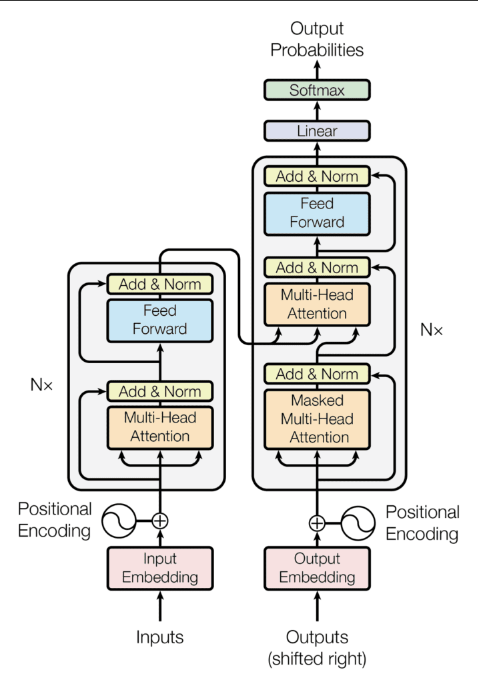

>Multi-head Attention에서 head dimension을 나누고 병합할 때 많이 쓰이는 shape 변환 함수를 선언해두자.

In [ ]:
def split_last(x, shape):
    "split the last dimension to given shape"
    shape = list(shape)
    assert shape.count(-1) <= 1
    if -1 in shape:
        shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))
    return x.view(*x.size()[:-1], *shape)

def merge_last(x, n_dims):
    "merge the last n_dims to a dimension"
    s = x.size()
    assert n_dims > 1 and n_dims < len(s)
    return x.view(*s[:-n_dims], -1)

>위에서 학습한 padding을 추가해주는 연산을 함수화한다.

In [ ]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.tensor(subsequent_mask, device=seq.device).byte()
    return subsequent_mask

### **예시 데이터 생성**

In [ ]:
sample_input = torch.tensor([[  101,  2572,  3217,  5831,  5496,  2010,  2567,  1010,  3183,  2002,
         2170,  1000,  1996,  7409,  1000,  1010,  1997,  9969,  4487, 23809,
         3436,  2010,  3350,  1012,   102,  7727,  2000,  2032,  2004,  2069,
         1000,  1996,  7409,  1000,  1010,  2572,  3217,  5831,  5496,  2010,
         2567,  1997,  9969,  4487, 23809,  3436,  2010,  3350,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]])



sample = [sample_input]

>실제 Transformer model에서 사용하는 configuration 을 선언해보자.

In [ ]:
sample_config = {
    "dim": 768,
    "dim_ff": 3072,
    "n_layers": 12,
    "p_drop_attn": 0.1,
    "n_heads": 12,
    "p_drop_hidden": 0.1,
    "max_len": 512,
    "n_segments": 2,
    "vocab_size": 30522
}

class AttributeDict(dict):
    def __getattr__(self, name):
        return self[name]
model_config = AttributeDict(sample_config)

In [ ]:
sample_input.size()

torch.Size([1, 128])

### **Activation function**

> Activation Function으로 사용할 GeLU를 구현한다.

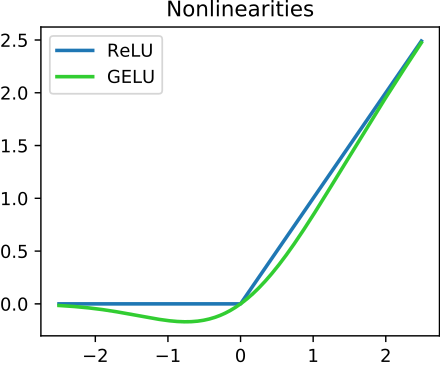

In [ ]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

### **Layer normalization**

> Transformer에서 사용할 Layer Normalization을 직접 구현한다.
>
>Mini-batch에 따라, 그리고 문장의 길이에 따라 결과가 달라지는 Batch Normalization 보다는 그에 무관하게 각각의 token feature를 정규화하는 Layer Normalization 기법이 sequence를 다루는 정규화 기법으로 알맞다.

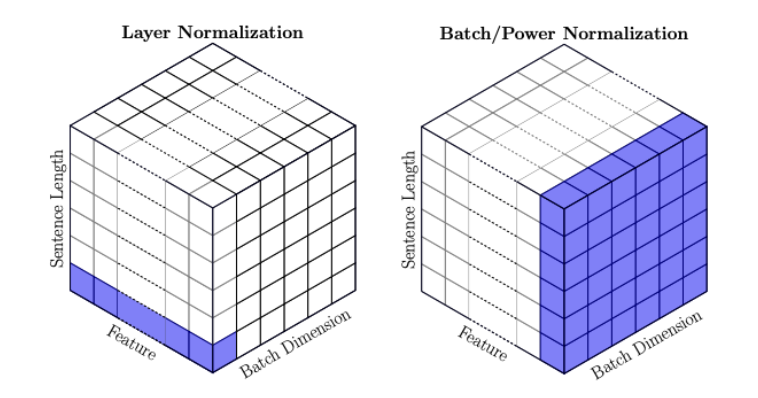

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, cfg, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(cfg.dim))
        self.beta  = nn.Parameter(torch.zeros(cfg.dim))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        # get mean, variance
        u = x.mean(-1, keepdim=True) # feature mean
        s = (x - u).pow(2).mean(-1, keepdim=True) # feature variance

        # normalize
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # (x - mean)/std

        return self.gamma * x + self.beta # gamma, beta를 이용해 mean, std 조정

### **Module1 - Embedding Layer**

>같은 단어의 경우에도 문장 안에서의 위치에 따라 다른 의미를 가지고 있을 수 있다.
>
>RNN의 경우 문장을 순서대로 입력하기 때문에 그 자체로 token의 위치 정보가 담길 수 있지만, transformer 모델에서는 각 token의 위치를 표현해줄 수 있는 수단이 없다.
>
>따라서 sin, cos 함수를 이용해서 위치를 표현해주는 positional embedding vector를 생성해 token의 embedding vector에 더해준다.

>예시로 3차원의 positional embedding layer를 구현해보자.

In [ ]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

pos_embed = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(10, 3),freeze=True) # position embedding
pos = torch.arange(10, dtype=torch.long).unsqueeze(0) # (batch, seq_len)

print(f'input position: {pos}')
embedded = pos_embed(pos)
print(f'positional embeddings: {embedded}')

input position: tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
positional embeddings: tensor([[[ 0.0000,  1.0000,  0.0000],
         [ 0.8415,  0.5403,  0.0022],
         [ 0.9093, -0.4161,  0.0043],
         [ 0.1411, -0.9900,  0.0065],
         [-0.7568, -0.6536,  0.0086],
         [-0.9589,  0.2837,  0.0108],
         [-0.2794,  0.9602,  0.0129],
         [ 0.6570,  0.7539,  0.0151],
         [ 0.9894, -0.1455,  0.0172],
         [ 0.4121, -0.9111,  0.0194]]])


>이를 기반으로 Transformer embedding layer를 구현해보자.

In [ ]:
class Embeddings(nn.Module):
    "The embedding module from word, position and token_type embeddings."
    def __init__(self, cfg):
        super().__init__()

        self.tok_embed = nn.Embedding(cfg.vocab_size, cfg.dim) # token embedding
        self.pos_embed = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(cfg.max_len, cfg.dim),freeze=True) # position embedding

        self.norm = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device) # 0,1,2,3,4,5, ..., seq_len-1
        pos = pos.unsqueeze(0).expand_as(x) # (S,) -> (B, S)

        e = self.tok_embed(x) + self.pos_embed(pos)
        return self.drop(self.norm(e))

In [ ]:
model = Embeddings(model_config)

In [ ]:
out = model(sample[0])
out.size()

torch.Size([1, 128, 768])

### **Module2 - Multihead-Attention**

>위에서 학습한 multihead-attention module이다.
>
>Configuration을 입력으로 받을 수 있도록 코드를 수정한다.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multi-Headed Dot Product Attention """
    def __init__(self, cfg):
        super().__init__()
        self.proj_q = nn.Linear(cfg.dim, cfg.dim)
        self.proj_k = nn.Linear(cfg.dim, cfg.dim)
        self.proj_v = nn.Linear(cfg.dim, cfg.dim)
        self.drop = nn.Dropout(cfg.p_drop_attn)
        self.scores = None
        self.n_heads = cfg.n_heads

    def forward(self, x, mask, x_q=None):
        """
        x: q(query), k(key), v(value)  (B(batch_size), S(seq_len), D(dim))
        mask : (B(batch_size), S(seq_len))
        """

        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        if x_q is None:
            q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        else:
            q, k, v = self.proj_q(x_q), self.proj_k(x), self.proj_v(x)
        q, k, v = (split_last(x, (self.n_heads, -1)).transpose(1, 2)
                   for x in [q, k, v])
        # (B, H, S, W) @ (B, H, W, S) -> (B, H, S, S) -softmax-> (B, H, S, S)
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1)) # @ == torch.matmul
        if mask is not None:
            mask = mask[:, None, :].float()
            scores -= torch.inf * (1.0 - mask)
        scores = self.drop(F.softmax(scores, dim=-1))
        # (B, H, S, S) @ (B, H, S, W) -> (B, H, S, W) -trans-> (B, S, H, W)
        h = (scores @ v).transpose(1, 2).contiguous()
        # -merge-> (B, S, D)
        h = merge_last(h, 2)
        self.scores = scores
        return h

### **Module3- Base feedforward network**

In [ ]:
class PositionWiseFeedForward(nn.Module):
    """ FeedForward Neural Networks for each position """
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg.dim, cfg.dim_ff)
        self.fc2 = nn.Linear(cfg.dim_ff, cfg.dim)

    def forward(self, x):
        # (B, S, D) -> (B, S, D_ff) -> (B, S, D)
        return self.fc2(gelu(self.fc1(x)))

### **Transformer**

> 위에서 구현한 함수들을 활용하여, Transformer Encoder block과 Decoder block, 그리고 전체 모델을 구현한다.

In [ ]:
class Encoder_Block(nn.Module):
    """ Transformer Block """
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(cfg)
        self.proj = nn.Linear(cfg.dim, cfg.dim)
        self.norm1 = LayerNorm(cfg)
        self.pwff = PositionWiseFeedForward(cfg)
        self.norm2 = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x, mask):
        h = self.attn(x, mask)
        h = self.norm1(x + self.drop(self.proj(h)))
        h = self.norm2(h + self.drop(self.pwff(h)))
        return h


class Decoder_Block(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.self_attention = MultiHeadAttention(cfg)
        self.encoder_attention = MultiHeadAttention(cfg)

        self.norm1 = LayerNorm(cfg)
        self.proj1 = nn.Linear(cfg.dim, cfg.dim)
        self.norm2 = LayerNorm(cfg)
        self.proj2 = nn.Linear(cfg.dim, cfg.dim)

        self.pwff = PositionWiseFeedForward(cfg)
        self.norm3 = LayerNorm(cfg)

        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self,x , enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):


        # self-attention -> add&norm
        h = self.self_attention(x, dec_self_attn_mask)
        h = self.norm1(x + self.drop(self.proj1(h)))

        # encoder attention -> add&norm
        h2 = self.encoder_attention(enc_outputs, dec_enc_attn_mask, x_q=h)
        h = self.norm2(h + self.drop(self.proj2(h2)))

        # feedforward network
        h = self.norm3(h + self.drop(self.pwff(h)))

        return h

class Transformer(nn.Module):
    """ Transformer with Self-Attentive Blocks"""
    def __init__(self, cfg):
        super().__init__()
        #====================encoder===========================
        self.encoder_embed = Embeddings(cfg)
        self.encoder_blocks = nn.ModuleList([Encoder_Block(cfg) for _ in range(cfg.n_layers)])

        #====================decoder============================
        self.decoder_embed = Embeddings(cfg)
        self.decoder_blocks = nn.ModuleList([Decoder_Block(cfg) for _ in range(cfg.n_layers)])

        #=========================================================
        self.projection = nn.Linear(cfg.dim, cfg.vocab_size)


    def forward(self, enc_inputs, dec_inputs):
        #============encoder============
        h = self.encoder_embed(enc_inputs)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        for block in self.encoder_blocks:
            h = block(h, enc_self_attn_mask)

        enc_outputs = h

        #============decoder============

        # self attention mask - subsequent masking
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).float()
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs).float()
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        # encoder attention mask - padding 에 masking
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)


        # embedding
        h = self.decoder_embed(dec_inputs)


        for block in self.decoder_blocks:
            h = block(h, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
        #============projection==========
        out = self.projection(h)

        return out

In [ ]:
model = Transformer(model_config)
model.cuda()
out = model(sample[0].cuda(),sample[0].cuda())
out.size()

torch.Size([1, 128, 30522])